In [1]:
using RCall, DataFrames, LogTopReg, Distributions
import Lazy.@>, Lazy.@>>

INFO: Recompiling stale cache file /home/seth/.julia/lib/v0.5/RCall.ji for module RCall.


R installation found at "/usr/lib/R"



Attaching package: ‘dplyr’

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

data.table 1.9.6  For help type ?data.table or https://github.com/Rdatatable/data.table/wiki
The fastest way to learn (by data.table authors): https://www.datacamp.com/courses/data-analysis-the-data-table-way

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, last



In [2]:
using LogTopReg
include("../juliafromR.jl");
Y,X,pss0 = getfocaldata();

  Bumped column 18 to type character on data row 6, field contains 'Activity (rest)'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they will now be just '0', and there may be inconsistencies with treatment of ',,' and ',NA,' too (if they occurred in this column before the bump). If this matters please rerun and set 'colClasses' to 'character' for this column. Please note that column type detection uses the first 5 rows, the middle 5 rows and the last 5 rows, so hopefully this message should be very rare. If reporting to datatable-help, please rerun and include the output from verbose=TRUE.
Warning in fread(files[i]) :
  Bumped column 19 to type character on data row 6, field contains 'In 2m? (8)'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they wil

In [3]:
R"library(rstan)"
R"topetho <- stan_model('~/code/topetho/categorical_topetho.stan')";
R"dat <- list(n=nrow(Y),K=3,B=ncol(Y)-3,Bs=sapply(Y[,-c(1:3),with=F],max),Y=as.matrix(Y[,-c(1:3),with=F]),alpha=1)";

rstan (Version 2.12.1, packaged: 2016-09-11 13:07:50 UTC, GitRev: 85f7a56811da)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


In [4]:
runs = 10;
ll = Vector{Float64}(runs);
r = Vector{Array{Float64,2}}(runs);
for i in 1:runs
    R"optout <- optimizing(topetho,dat,verbose=F)";
    ll[i] = rcopy(R"optout$value");
    r[i] = rcopy(R"optout$par[str_detect(names(optout$par),'^r\\[')] %>% matrix(nrow=dat$K,ncol=dat$n,byrow = T)")
end

STAN OPTIMIZATION COMMAND (LBFGS)
init = random
save_iterations = 1
init_alpha = 0.001
tol_obj = 1e-12
tol_grad = 1e-08
tol_param = 1e-08
tol_rel_obj = 10000
tol_rel_grad = 1e+07
history_size = 5
seed = 577314241
initial log joint probability = -223827
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
STAN OPTIMIZATION COMMAND (LBFGS)
init = random
save_iterations = 1
init_alpha = 0.001
tol_obj = 1e-12
tol_grad = 1e-08
tol_param = 1e-08
tol_rel_obj = 10000
tol_rel_grad = 1e+07
history_size = 5
seed = 175996696
initial log joint probability = -241726
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
STAN OPTIMIZATION COMMAND (LBFGS)
init = random
save_iterations = 1
init_alpha = 0.001
tol_obj = 1e-12
tol_grad = 1e-08
tol_param = 1e-08
tol_rel_obj = 10000
tol_rel_grad = 1e+07
history_size = 5
seed = 214766971
initial log joint probability = -236752
Optimization terminated norma

In [3]:
r = readcsv("/home/seth/analysis/logtopreg/optimout.csv");

In [26]:
zflat = mapslices(x -> rand(Categorical(x)),r,2);
z = Vector{Vector{Int64}}(length(Y));
nd = map(x -> size(x)[2],Y);
guh = 1;
for i in 1:length(Y)
    z[i] = zflat[guh:(guh+nd[i]-1)];
    guh += nd[i];
end

In [88]:
K = 10;
niter = 1000;
thin = 4;
ns = div(niter,thin);

In [28]:
@time fit = simplemix(hcat(Y...),pss0,10,zinit=vcat(z...),iter=niter,thin=thin);

 68.125996 seconds (1.10 G allocations: 22.013 GB, 3.31% gc time)


In [89]:
@time fit2 = topiclmm(Y,X,pss0,10,zinit=z,iter=niter,thin=thin);

336.942035 seconds (4.34 G allocations: 90.665 GB, 3.05% gc time)


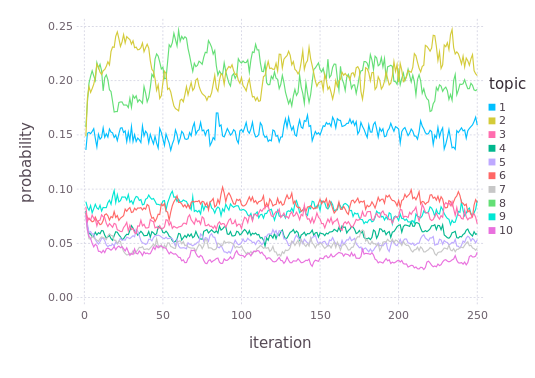

In [30]:
using Gadfly
mudat = DataFrame(probability = mapslices(softmax,fit[:η],1)[:],topic=repeat(map(string,1:K),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K]));
plot(mudat,x="iteration",y="probability",color="topic",Geom.line)

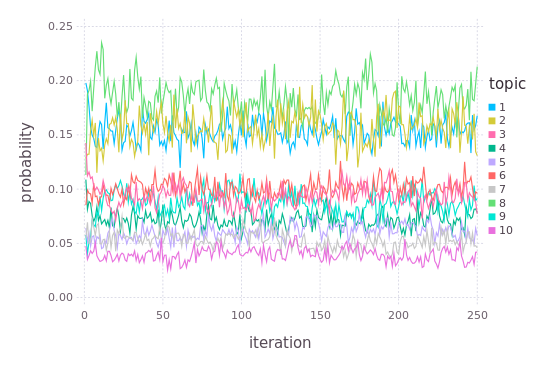

In [90]:
mudat = DataFrame(probability = mapslices(softmax,fit2[:μ],1)[:],topic=repeat(map(string,1:K),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K]));
plot(mudat,x="iteration",y="probability",color="topic",Geom.line)

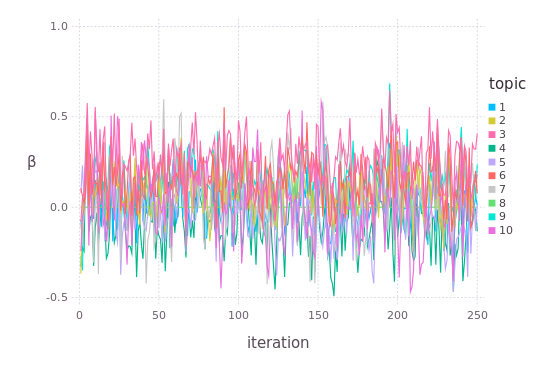

In [113]:
bdat = DataFrame(β = vec( refβ(fit2[:β],fit2[:μ]) ),
iteration = repeat(collect(1:ns),inner=[K*p]),topic = repeat(map(string,1:K),inner=[p],outer=[ns]),
coef=repeat(map(string,1:p),outer=[K*ns]));
plot(bdat[bdat[:coef].=="9",:],y="β",x="iteration",color="topic",Geom.line)